In [1]:
#!pip

## r1_correctLC

In [2]:
from astropy import stats #for MAD

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from lightkurve import LightCurve
import astropy.units as u
import logging
#import batman-package as batman
#batman = __import__("batman-package")
import matplotlib
#from basic_functions import stop

logging.basicConfig(format='%(asctime)s %(levelname)s: %(name)s(%(funcName)s): %(message)s', level=logging.DEBUG)

import tessutils #NOT the normal utils!

#dataDir = "data"
#downloadDir = "mastDownload/TESS"
#outdir = "results_notCorrectedForSineLong"
#correctSine = False

###################################################################################################


2019-12-02 15:31:58,064 DEBUG: matplotlib.pyplot(switch_backend): Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [4]:
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
from astropy.io import fits 
import os
from lightkurve import LightCurve
from lightkurve import BoxLeastSquaresPeriodogram as BLS
#import lightkurve as lk
import numpy as np
import requests
import gzip 
import pickle

import logging
logger = logging.getLogger(__name__)

import subprocess
from matplotlib import rc

import os
import shutil

In [5]:
lc = None
folderName = 'tess2018206045859-s0001-0000000092352620-0120-s'
downloadDir = 'CleanPath/LowMags/TIC_92352620/' #Path must flow like this

lc_load, sectors = tessutils.loadLC(folderName, downloadDir, fluxType="PDCSAP", normalised=True)
lcOri = lc_load.copy()

# Show what it looks like
#plt.figure()
#plt.scatter(lc.time, lc.flux, label="LC", marker='.', s=5)
#lcB = lc.bin(100, method="median")
#plt.scatter(lcB.time, lcB.flux, label="LC", marker='.', s=5)
#plt.savefig(os.path.join(downloadDir, "TIC_92352620_raw.pdf"))
#plt.show()

2019-12-02 15:31:58,194 INFO: tessutils(loadLC): Cadence is 2 min for CleanPath/LowMags/TIC_92352620/tess2018206045859-s0001-0000000092352620-0120-s\tess2018206045859-s0001-0000000092352620-0120-s_lc.fits
D:\Python\Anaconda\lib\site-packages\lightkurve\lightcurve.py:108: LightkurveWarning: LightCurve object contains NaN times
  warnings.warn('LightCurve object contains NaN times', LightkurveWarning)


## Median Detrend

In [6]:
def medianDetrend(lc, windowFactorDurationTransit, returnMedians=False): #remove durationTransitHour
    
    #durationTransit = durationTransitHour / 24.
    window = windowFactorDurationTransit # * durationTransit
    
    t = lc.time / window
    t -= np.amin(t)
    tMax = int(np.ceil(np.amax(t)))
    
    medians = []
    ts = []
    te = []
    for windowStart in range(0, tMax):
        ts.append(windowStart)
        te.append(windowStart+1.)
        currentIds = np.where(np.logical_and(t >= windowStart, t < windowStart+1.))
        median = np.nanmedian(lc.flux[currentIds])
        medians.append(median)
        lc.flux_err[currentIds] /= median        
        lc.flux[currentIds] /= median

    if returnMedians:
        return lc, medians, ts, te, t
    return lc 

## (Removed) Light Curve

In [7]:
plt.rc('font', family="Times New Roman")
plt.rc('font', size=14)

## (Removed) Light Curve (Folding "In Phase")

## (Removed) DeltaT Bin

## (Removed) Best-Fit Model

In [8]:
time = max(lc_load.time)-min(lc_load.time)
time
lc_load == lcOri

False

In [9]:
time = max(lc_load.time)-min(lc_load.time)
lcTransit = lc_load.copy()
def gridfreq(lc, N=10):
    periods=[]
    phases=[]
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        plt.scatter(phase, (lcTransit.flux-1.)*1e6, marker=".", color="k", s=3)
        plt.title("Folded at {} days".format('%.3f'%(period))+' (with outliers)')
        plt.xlabel("Phase")
        plt.ylabel("Difference to normalized flux [ppm]")
        plt.savefig(os.path.join(downloadDir,"PhaseFold_beforeout{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    return periods


#gridfreq(lcTransit)

## Coloring of Outliers

In [10]:
time = max(lc_load.time)-min(lc_load.time)
lcTransit = lc_load.copy()
def gridfreq_col(lc, N=10):
    periods=[]
    phases=[]
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        
        flux_nomad = lc.flux-1
        mad = stats.median_absolute_deviation(lc.flux)
        std = np.std(flux_nomad)
        
        col = ['k']*len(phase)
        col = np.array(col)
        col[np.where(flux_nomad >= 4*mad)] = 'b'
        col[np.where(flux_nomad <= -4*mad)] = 'r'
        ind_norm = np.where(col == 'k')
        ind_outl_pos = np.where(col == 'b')
        ind_outl_neg = np.where(col == 'r')
        
        #Now plot number of outliers PER WINDOW, and see if this it matches with the colored light curve.
        
        ##Outlier removal below
        #flux_mad = np.where(flux_nomad > 2*mad, 0, flux_nomad)
        ##Outlier removal above
        
        plt.scatter(phase, (lcTransit.flux-1.)*1e6, marker=".", color=col, s=3)
        plt.title("Folded at {} days".format('%.3f'%(period))+' (with outliers)')
        plt.xlabel("Phase")
        plt.ylabel("Difference to normalized flux [ppm]")
        plt.savefig(os.path.join(downloadDir,"PhaseFold_markedout{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    return periods

#gridfreq_col(lcTransit)

## Removal of Outliers (with astropy)

In [11]:
lcTransit = lc_load.copy()
def gridfreq(lc,N=10):
    periods=[]
    phases=[]
    time = max(lc.time)-min(lc.time)
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        ##Outlier removal below
        flux_nomad = lc.flux-1
        mad = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)
        ##Outlier removal above
        plt.scatter(phase, (flux_mad)*1e6, marker=".", color="k", s=3)
        plt.title("Folded at {} days".format('%.3f'%(period)))
        plt.xlabel("Phase")
        plt.ylabel("Difference to normalized flux [ppm]")
        plt.savefig(os.path.join(downloadDir,"PhaseFold_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    return periods

#gridfreq(lcTransit)

In [12]:
lcTransit = lc_load.copy()
#test = BLS.from_lightcurve(lcTransit)
test = BLS.from_lightcurve(lcTransit)
test2 = BLS.get_transit_model(test)
#test2.period_at_max_power
test2.time = test2.time-test2.time[0]
#test2.plot()

No period specified. Using period at max power
2019-12-02 15:31:58,424 WARNING: lightkurve.periodogram(get_transit_model): No period specified. Using period at max power
No duration specified. Using duration at max power
2019-12-02 15:31:58,425 WARNING: lightkurve.periodogram(get_transit_model): No duration specified. Using duration at max power
No transit time specified. Using transit time at max power
2019-12-02 15:31:58,426 WARNING: lightkurve.periodogram(get_transit_model): No transit time specified. Using transit time at max power


## Shifting to first transit (Works)

In [13]:
test = BLS.from_lightcurve(lcTransit)
test2 = BLS.get_transit_model(test)
test2.time = test2.time-test2.time[0]
indextest = np.where(test2.flux == min(test2.flux))[0]
indextest[0]

No period specified. Using period at max power
2019-12-02 15:31:58,573 WARNING: lightkurve.periodogram(get_transit_model): No period specified. Using period at max power
No duration specified. Using duration at max power
2019-12-02 15:31:58,574 WARNING: lightkurve.periodogram(get_transit_model): No duration specified. Using duration at max power
No transit time specified. Using transit time at max power
2019-12-02 15:31:58,575 WARNING: lightkurve.periodogram(get_transit_model): No transit time specified. Using transit time at max power


2002

In [14]:
test = BLS.from_lightcurve(lcTransit)
test2 = BLS.get_transit_model(test)
test3 = BLS.from_lightcurve(test2)

No period specified. Using period at max power
2019-12-02 15:31:58,721 WARNING: lightkurve.periodogram(get_transit_model): No period specified. Using period at max power
No duration specified. Using duration at max power
2019-12-02 15:31:58,722 WARNING: lightkurve.periodogram(get_transit_model): No duration specified. Using duration at max power
No transit time specified. Using transit time at max power
2019-12-02 15:31:58,723 WARNING: lightkurve.periodogram(get_transit_model): No transit time specified. Using transit time at max power


In [15]:
per = test.period_at_max_power
#print(per)
#BLS.show_properties(test)

In [16]:
#I will need the period/phase right before and after transit, not just period at max transit.
N=12
#model = BLS.get_transit_model(test)
#time = max(model.time)-min(model.time)
#for i in np.arange(1/4.8, 1/3.6, (1/time * 1/N)):
    #period = 1/i
    #phase = (lc.time % period)
    #plt.plot(phase, model.flux)
    #plt.title("BLS Transit Model at {} days".format('%.3f'%(period)))
    #plt.show()

## Plotting a Phase Fold via BoxLeastSquares

In [17]:
def phasefold(lc):
    time = max(lc.time)-min(lc.time)
    bls = BLS.from_lightcurve(lc)
    period = bls.period_at_max_power
    period = period.value #value in days
    phase = (lc.time % period)
    plt.scatter(phase, (lc.flux-1.)*1e6, marker=".", color="k", s=3)
    plt.title("Folded at {} days".format('%.3f'%(period))+' (with outliers)')
    plt.xlabel("Phase")
    plt.ylabel("Difference to normalized flux [ppm]")
    #plt.savefig(os.path.join(downloadDir,"PhaseFold_beforeout{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
    plt.show()

#phasefold(lcTransit)

## Plotting a Phase Fold via BoxLeastSquares (with Outlier Removal)

In [18]:
def phasefold2(lc):
    time = max(lc.time)-min(lc.time)
    bls = BLS.from_lightcurve(lc)
    period = bls.period_at_max_power
    period = period.value
    #period = 2.9
    phase = (lc.time % period)
    
    flux_nomad = lc.flux-1
    mad = stats.median_absolute_deviation(lc.flux)
    std = np.std(flux_nomad)
        
    col = ['k']*len(phase)
    col = np.array(col)
    col[np.where(flux_nomad >= 4*mad)] = 'cyan'
    col[np.where(flux_nomad <= -4*mad)] = 'r'
    ind_norm = np.where(col == 'k')
    ind_outl_pos = np.where(col == 'cyan')
    ind_outl_neg = np.where(col == 'r')
    
    flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)

    plt.scatter(phase, (flux_mad)*1e6, marker=".", color=col, s=3)
    plt.title("Folded at {} days".format('%.3f'%(period)))
    plt.xlabel("Phase")
    plt.ylabel("Difference to normalized flux [ppm]")
    #plt.savefig(os.path.join(downloadDir,"PhaseFold_beforeout{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
    plt.show()

#phasefold2(lcTransit)

2019-12-02 15:31:59,271 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: Matching :family=Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=16.8.
2019-12-02 15:31:59,272 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,273 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,274 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,275 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,276 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 

2019-12-02 15:31:59,318 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi' (FRADM.TTF) normal normal demi normal>) = 10.24
2019-12-02 15:31:59,319 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal bold normal>) = 11.335
2019-12-02 15:31:59,320 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) normal normal 400 condensed>) = 10.25
2019-12-02 15:31:59,321 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,322 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUAB.TTF) normal normal book normal>) = 10.05
2019-12-02 15:31:59,323 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
2019-12-02 15:3

2019-12-02 15:31:59,371 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal regular normal>) = 10.05
2019-12-02 15:31:59,373 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Playbill' (PLAYBILL.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,374 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,374 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Colonna MT' (COLONNA.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,375 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,376 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,377 DEBUG: matplotlib

2019-12-02 15:31:59,423 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candaral.ttf) normal normal light normal>) = 10.24
2019-12-02 15:31:59,424 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constanz.ttf) italic normal bold normal>) = 11.335
2019-12-02 15:31:59,425 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNT.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,426 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal bold condensed>) = 11.535
2019-12-02 15:31:59,427 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILB____.TTF) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,428 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,429 DEBUG: matplotlib.f

2019-12-02 15:31:59,479 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANS.TTF) normal normal regular normal>) = 10.05
2019-12-02 15:31:59,480 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal bold normal>) = 11.335
2019-12-02 15:31:59,480 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,481 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,482 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibri.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,483 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,484 DEBUG: matplotlib.font_m

2019-12-02 15:31:59,541 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Book' (FRABKIT.TTF) italic normal book normal>) = 11.05
2019-12-02 15:31:59,542 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
2019-12-02 15:31:59,543 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITEI.TTF) italic normal 400 normal>) = 11.05
2019-12-02 15:31:59,544 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
2019-12-02 15:31:59,545 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tempus Sans ITC' (TEMPSITC.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,546 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,547 DEBUG: mat

2019-12-02 15:31:59,599 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'SimSun' (simsun.ttc) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,600 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookshelf Symbol 7' (BSSYM7.TTF) normal normal book normal>) = 10.05
2019-12-02 15:31:59,601 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
2019-12-02 15:31:59,604 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,605 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
2019-12-02 15:31:59,606 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Vivaldi' (VIVALDII.TTF) italic normal 400 normal>) = 11.05
2019-12-02 15:31:59,608 DEBUG: matplotlib.font_

2019-12-02 15:31:59,662 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,663 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal book normal>) = 10.05
2019-12-02 15:31:59,663 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,664 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Niagara Engraved' (NIAGENG.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,665 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gadugi' (gadugi.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,666 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial Rounded MT Bold' (ARLRDBD.TTF) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,66

2019-12-02 15:31:59,883 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
2019-12-02 15:31:59,884 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,885 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,885 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,886 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,887 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 norma

2019-12-02 15:31:59,927 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,928 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal light normal>) = 10.24
2019-12-02 15:31:59,928 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,929 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gadugi' (gadugib.ttf) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,930 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bauhaus 93' (BAUHS93.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,931 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal roman normal>) = 0.14500000000000002
2019-12-02 15:31:59,9

2019-12-02 15:31:59,977 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,978 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (courbd.ttf) normal normal bold normal>) = 10.335
2019-12-02 15:31:59,979 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,980 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,980 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal semibold normal>) = 11.24
2019-12-02 15:31:59,981 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:31:59,982 DEBUG: matplotlib.font_m

2019-12-02 15:32:00,034 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPE.TTF) normal normal regular normal>) = 10.05
2019-12-02 15:32:00,035 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (palabi.ttf) italic normal bold normal>) = 11.335
2019-12-02 15:32:00,037 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:32:00,037 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:32:00,038 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Script' (segoescb.ttf) normal normal bold normal>) = 10.335
2019-12-02 15:32:00,039 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal book normal>) = 10.05
2019-12-02 15:3

2019-12-02 15:32:00,090 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguibli.ttf) italic normal black normal>) = 11.525
2019-12-02 15:32:00,092 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal bold normal>) = 10.335
2019-12-02 15:32:00,093 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BI.TTF) italic normal bold normal>) = 11.335
2019-12-02 15:32:00,094 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
2019-12-02 15:32:00,095 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal roman normal>) = 1.145
2019-12-02 15:32:00,096 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal bold normal>) = 11.335
2019-12-02 15:32:00,0

2019-12-02 15:32:00,145 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
2019-12-02 15:32:00,146 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Baskerville Old Face' (BASKVILL.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:32:00,146 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal bold normal>) = 11.335
2019-12-02 15:32:00,147 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
2019-12-02 15:32:00,148 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSD.TTF) normal normal roman normal>) = 10.145
2019-12-02 15:32:00,149 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal medium normal>) = 10.145
2019-12

2019-12-02 15:32:00,197 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 11.05
2019-12-02 15:32:00,198 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palace Script MT' (PALSCRI.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:32:00,199 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:32:00,200 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal bold normal>) = 10.335
2019-12-02 15:32:00,201 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
2019-12-02 15:32:00,202 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:32:00,203 DEBUG: matplotlib.font_manager

2019-12-02 15:32:00,255 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUABI.TTF) italic normal book normal>) = 11.05
2019-12-02 15:32:00,256 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Californian FB' (CALIFR.TTF) normal normal 400 normal>) = 10.05
2019-12-02 15:32:00,257 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambriai.ttf) italic normal 400 normal>) = 11.05
2019-12-02 15:32:00,258 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Berlin Sans FB' (BRLNSB.TTF) normal normal bold normal>) = 10.335
2019-12-02 15:32:00,260 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Regular.otf) normal normal 400 normal>) = 10.05
2019-12-02 15:32:00,261 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal bold normal>) = 10.335
2019-12-02 15

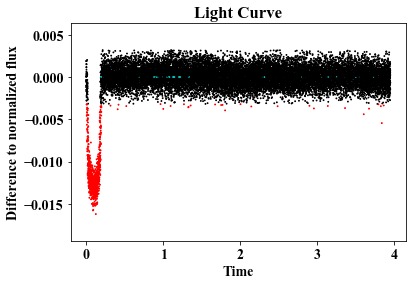

In [19]:
def phasefold3(lc):
    time = max(lc.time)-min(lc.time)
    bls = BLS.from_lightcurve(lc)
    period = bls.period_at_max_power
    period = period.value
    phase = (lc.time % period)
    
    flux_nomad = lc.flux-1
    mad = stats.median_absolute_deviation(lc.flux)
    std = np.std(flux_nomad)
        
    col = ['k']*len(phase)
    col = np.array(col)
    col[np.where(flux_nomad >= 4*mad)] = 'cyan'
    col[np.where(flux_nomad <= -4*mad)] = 'r'
    ind_norm = np.where(col == 'k')
    ind_outl_pos = np.where(col == 'cyan')
    ind_outl_neg = np.where(col == 'r')
    
    flux_mad = np.where(flux_nomad >= 4*mad, 0, flux_nomad)
    flux_notrans = np.where(flux_mad <= -4*mad, 0, flux_mad) #This is no transit as well as no other outliers at all. Not good.

    plt.scatter(phase, flux_mad, marker=".", color=col, s=3)
    plt.title("Light Curve")
    plt.xlabel("Time")
    plt.ylabel("Difference to normalized flux")
    #plt.savefig(os.path.join(downloadDir,"PhaseFold_beforeout{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
    plt.show()

phasefold3(lcTransit)

In [20]:
tt = test.transit_time
per = test.period
dur = test.duration
stt = np.sort(tt)
tt

array([0.17919576, 0.03706271, 0.06982083, ..., 4.31717612, 1.64494344,
       4.12763253])

In [21]:
tt = test.transit_time
print(tt)

[0.17919576 0.03706271 0.06982083 ... 4.31717612 1.64494344 4.12763253]


In [22]:
time = lc_load.time-lc_load.time[0]
tottime = max(lc_load.time)-min(lc_load.time)
tottime/per.value

array([110.84902671, 110.75931232, 110.66959794, ...,   3.19176744,
         3.10205305,   3.01233867])

In [23]:
tottime = max(lc_load.time)-min(lc_load.time)
time = (lc_load.time-lc_load.time[0])
bls = BLS.from_lightcurve(lc_load)
period = bls.period_at_max_power
period = period.value #/ 1.3
dur = bls.duration_at_max_power
dur = dur.value
phase = (lc_load.time % period)
period - time[2002]

1.1029417049750085

In [24]:
#%matplotlib notebook
def phasefold4(lc):
    tottime = max(lc.time)-min(lc.time)
    time = (lc.time-lc.time[0])
    bls = BLS.from_lightcurve(lc)
    period = bls.period_at_max_power
    period = period.value
    dur = bls.duration_at_max_power
    dur = dur.value
    phase = (lc.time % period)
    
    flux_nomad = lc.flux-1
    mad = stats.median_absolute_deviation(lc.flux)
    std = np.std(flux_nomad)
         
    col = ['k']*len(phase)
    col = np.array(col)
    col[np.where(flux_nomad >= 4*mad)] = 'cyan'
    col[np.where(flux_nomad <= -4*mad)] = 'r'
    ind_norm = np.where(col == 'k')
    ind_outl_pos = np.where(col == 'cyan')
    ind_outl_neg = np.where(col == 'r')
    
    number_of_trans = int(np.ceil(tottime/period))

    model = BLS.get_transit_model(bls)
    model.time = model.time-model.time[0]
    firsttrans_ind = np.where(model.flux == min(model.flux))[0]
    firsttrans = firsttrans_ind[0]
    #const = period - time[2002] #Works for TIC9235... 
    const = period - time[firsttrans]
    
    for k in range (1, number_of_trans):
        trans_start = (k*period)-const
        trans_end = (k*period)-const + (dur)
        plt.axvline(x=(k*period)-const, c='gray', linestyle='--')
        plt.axvline(x=(k*period)-const + (dur), c='gray', linestyle='--')
        for j in range (0, len(time)):
            if trans_start < time[j] and time[j] < trans_end:
                flux_nomad[j]=0
            else:
                flux_nomad[j]=flux_nomad[j]
        flux_notrans = flux_nomad
    
    #flux_notrans = np.where(flux_notrans >= 4*mad, 0, flux_notrans)
    
    plt.scatter(time, flux_notrans, marker=".", color=col, s=3)
    plt.title("Light Curve without Main Transit")
    plt.xlabel("Time (days)")
    plt.ylabel("Difference to normalized flux")
    #plt.savefig(os.path.join(downloadDir,"PhaseFold_beforeout{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
    plt.show()

#phasefold4(lcOri)

No period specified. Using period at max power
2019-12-02 15:32:00,963 WARNING: lightkurve.periodogram(get_transit_model): No period specified. Using period at max power
No duration specified. Using duration at max power
2019-12-02 15:32:00,964 WARNING: lightkurve.periodogram(get_transit_model): No duration specified. Using duration at max power
No transit time specified. Using transit time at max power
2019-12-02 15:32:00,965 WARNING: lightkurve.periodogram(get_transit_model): No transit time specified. Using transit time at max power


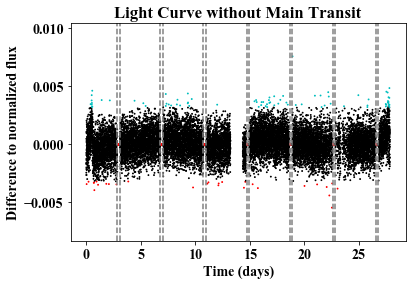

In [25]:
phasefold4(lcTransit)

In [26]:
#%matplotlib notebook
def removetrans(lc):
    tottime = max(lc.time)-min(lc.time)
    time = (lc.time-lc.time[0])
    bls = BLS.from_lightcurve(lc)
    period = bls.period_at_max_power
    period = period.value
    dur = bls.duration_at_max_power
    dur = dur.value
    phase = (lc.time % period)
    
    flux_nomad = lc.flux-1
    number_of_trans = int(np.ceil(tottime/period))

    model = BLS.get_transit_model(bls)
    model.time = model.time-model.time[0]
    firsttrans_ind = np.where(model.flux == min(model.flux))[0]
    firsttrans = firsttrans_ind[0]
    #const = period - time[2002] #Works for TIC9235... 
    const = period - time[firsttrans]
    
    for k in range (1, number_of_trans):
        trans_start = (k*period)-const
        trans_end = (k*period)-const + (dur)
        for j in range (0, len(time)):
            if trans_start < time[j] and time[j] < trans_end:
                flux_nomad[j]=0
            else:
                flux_nomad[j]=flux_nomad[j]
    flux_notrans = flux_nomad
    
    #flux_notrans = np.where(flux_notrans >= 4*mad, 0, flux_notrans)
    
    return flux_notrans

#removetrans(lcOri)

In [27]:
def window1(a, w=100, o=10, copy=False):
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    print(a.strides)
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    if copy:
        return view.copy()
    else:
        return view
    #return (o-w, o+w)
    
#def window2(a, startpos):
    #a[N:N+11]
    
def count1(a, mad, std):
    firstapps = []
    #firstapp = (mad-lc)/std
    firstapp = (a - mad)/std
    for i in range (0, len(firstapp)):
        if firstapp[i] < std:
            firstapp[i] = 1
        else:
            firstapp[i] = 0
    firstapps.append(firstapp)
    outlier_count = np.count_nonzero(firstapps)
    return outlier_count

In [28]:
N = 10 
dt=5
time = max(lc_load.time)-min(lc_load.time)
dt = dt/24 #converting to day
period = 3.9611876601163045
phase = (lc_load.time % period)

##Binning below
#s = period / dt
#lcB = lc.bin(binsize=s, method='median') #Do not bin until neg outliers are removed
#phasebin = (lcB.time % period) #Do not bin until neg outliers are removed
##Binninng above
                    
## +Outlier removal below
flux_nomad = lc_load.flux-1
mad = stats.median_absolute_deviation(flux_nomad)
flux_mad = np.where(flux_nomad > 2*mad, 0, flux_nomad)
## +Outlier removal above
    
## -Outlier removal below
    
std = np.std(flux_nomad)
windows = window1(flux_nomad)
#print((mad-windows[5])/std)
count1(windows[5], mad, std)

#firstapps=[]
#for i in range(0, 11):
    #for j in range(0, len(windows[3])):
    #firstapp = (mad - windows[3][j])/std
    #firstapps.append(firstapp)
#return firstapps
    
## -Outlier removal above

(4,)


76

## Binning

In [29]:
def meandt(lc, N=10, dt=5):
    periods = []
    time = max(lc_load.time)-min(lc_load.time)
    dt = dt/24 #converting to day
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        
        ##Binning below
        s = period / dt
        lcB = lc.bin(binsize=s, method='median')
        phasebin = (lcB.time % period)
        ##Binninng above
                    
        ##Outlier removal below
        flux_nomad = lcB.flux-1
        mad = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 2*mad, 0, flux_nomad)
        ##Outlier removal above
    
        plt.scatter(phasebin, (flux_mad)*1e6, marker=".", color="k", s=5)
        plt.title("Folded at {} days".format('%.3f'%(period))+', binned at {} days'.format('%.3f'%(dt)))
        plt.xlabel("Phase")
        plt.ylabel("Difference to normalized flux [ppm]")
        plt.savefig(os.path.join(downloadDir,"PhaseFoldBin_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
    return periods

#meandt(lc_load)

## Window Sliding

In [30]:
def window(a, w=50, o=5, copy=False):
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    if copy:
        return view.copy()
    else:
        return view
    #return (o-w, o+w)
    
#def window2(a, startpos):
    #a[N:N+11]
    
def count2(a, mad):
    firstapps = []
    #firstapp = (mad-lc)/std
    #firstapp = (a - mad)/std
    #firstapp = a
    firstapp = np.zeros(len(a))
    for i in range (0, len(a)):
        if a[i] <= -4*mad:
            firstapp[i] = 1
        else:
            firstapp[i] = 0
    firstapps.append(firstapp)
    outlier_count = np.count_nonzero(firstapp)
    return outlier_count

def count3(a, mad):
    firstapps = []
    firstapp = a
    firstapp[np.where(a >= 4*mad)] = 0
    firstapp[np.where(a <= -4*mad)] = 1
    outlier_count = np.count_nonzero(firstapp)
    return outlier_count


## Counting Outliers In Terms of Phase (Works!)

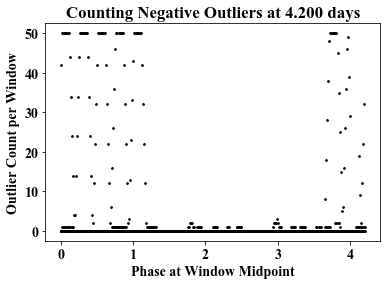

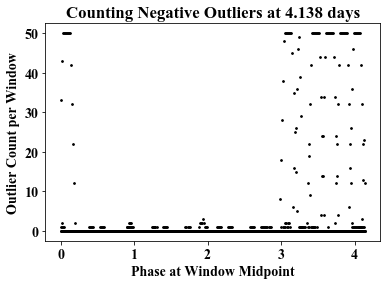

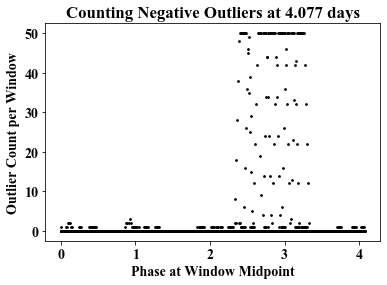

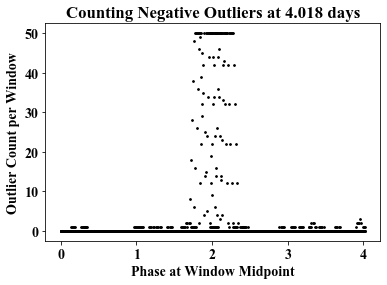

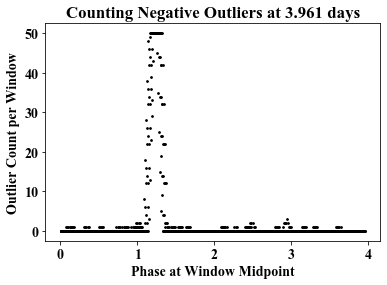

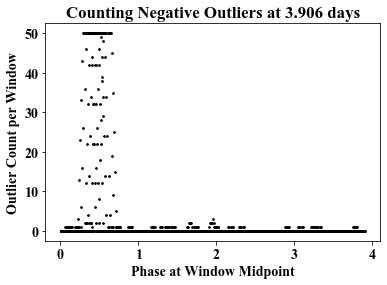

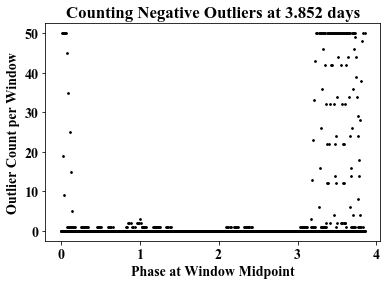

[4.2,
 4.1376374607581035,
 4.077099771591672,
 4.018307989481871,
 3.9611876601163045,
 3.9056685033252827,
 3.851684124605596]

In [31]:
def gridfreqcount(lc, upper=4.2, lower=3.8, N=10):
    periods=[]
    phases=[]
    time = max(lc.time)-min(lc.time)
    for i in np.arange(1/upper, 1/lower, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        
        ## Pos outlier removal below
        flux_nomad = lc.flux-1
        MAD = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)
        ## Pos outlier removal above
        
        ##Counting neg outlier below
        col = [0]*len(phase)
        col = np.array(col)
        col[np.where(flux_nomad <= -4*MAD)] = 1 #'r'
        #print(len(col))
        windows = window(col, w=50, o=10)
        window_phase = window(phase, w=50, o=10)
        #print(windows[50])
        counts = []
        for j in range(0, len(windows)):
            outlier_count = np.count_nonzero(windows[j])
            counts.append(outlier_count)
        ##Counting neg outlier above
        
        #print(counts)
        plt.scatter(window_phase[:,0], counts, marker="o", color="k", s=3)
        #plt.scatter(phase, (flux_mad)*1e6, marker=".", color="k", s=3)
        plt.title("Counting Negative Outliers at {} days".format('%.3f'%(period)))
        plt.xlabel("Phase at Window Midpoint")
        plt.ylabel("Outlier Count per Window")
        #plt.savefig(os.path.join(downloadDir,"NegCount_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    return periods

gridfreqcount(lcTransit)

In [32]:
def gridfreqcount_new(lc, upper=4.2, lower=3.8, N=10):
    periods=[]
    phases=[]
    time = max(lc.time)-min(lc.time)
    for i in np.arange(1/upper, 1/lower, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        
        ## Pos outlier removal below
        flux_nomad = lc.flux-1
        MAD = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)
        ## Pos outlier removal above
        
        ##Counting neg outlier below
        col = [0]*len(phase)
        col = np.array(col)
        col[np.where(flux_nomad <= -4*MAD)] = 1 #'r'
        windows = window(col, w=25, o=25)
        window_phase = window(phase, w=25, o=25)
        counts = []
        for j in range(0, len(windows)):
            outlier_count = np.count_nonzero(windows[j])
            counts.append(outlier_count)
        ##Counting neg outlier above
        
        #print(counts)
        plt.scatter(window_phase[:,0], counts, marker="o", color="k", s=3)
        #plt.scatter(phase, (flux_mad)*1e6, marker=".", color="k", s=3)
        plt.title("Counting Negative Outliers at {} days".format('%.3f'%(period)))
        plt.xlabel("Phase at Window Midpoint")
        plt.ylabel("Outlier Count per Window")
        #plt.savefig(os.path.join(downloadDir,"NegCount_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    #return periods

In [33]:
#notrans = removetrans(lcTransit)
#plt.scatter(lcTransit.time-min(lcTransit.time), notrans, marker=".", color='k', s=3)
#plt.title('New Light Curve')
#plt.show()

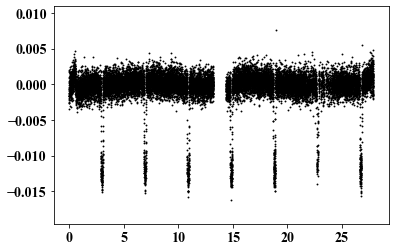

In [37]:
plt.scatter(lcTransit.time-min(lcTransit.time), lcTransit.flux-1, marker=".", color='k', s=3)

No period specified. Using period at max power
2019-12-02 15:32:16,434 WARNING: lightkurve.periodogram(get_transit_model): No period specified. Using period at max power
No duration specified. Using duration at max power
2019-12-02 15:32:16,435 WARNING: lightkurve.periodogram(get_transit_model): No duration specified. Using duration at max power
No transit time specified. Using transit time at max power
2019-12-02 15:32:16,436 WARNING: lightkurve.periodogram(get_transit_model): No transit time specified. Using transit time at max power


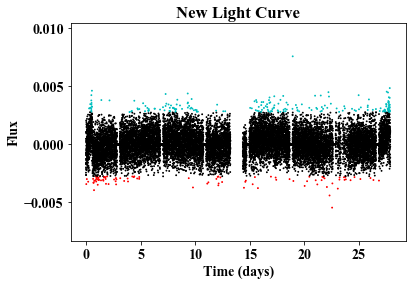

In [36]:
notrans = removetrans(lcTransit)
std = np.std(notrans)
mad = stats.median_absolute_deviation(notrans)
col_new = ['k']*len(notrans)
col_new = np.array(col_new)
col_new[np.where(notrans >= 4*mad)] = 'cyan'
col_new[np.where(notrans <= -4*mad)] = 'r'
plt.scatter(lcTransit.time-min(lcTransit.time), notrans, marker=".", color=col_new, s=3)
plt.title('New Light Curve')
plt.xlabel('Time (days)')
plt.ylabel('Flux')
plt.show()

No period specified. Using period at max power
2019-12-02 15:33:42,390 WARNING: lightkurve.periodogram(get_transit_model): No period specified. Using period at max power
No duration specified. Using duration at max power
2019-12-02 15:33:42,391 WARNING: lightkurve.periodogram(get_transit_model): No duration specified. Using duration at max power
No transit time specified. Using transit time at max power
2019-12-02 15:33:42,392 WARNING: lightkurve.periodogram(get_transit_model): No transit time specified. Using transit time at max power


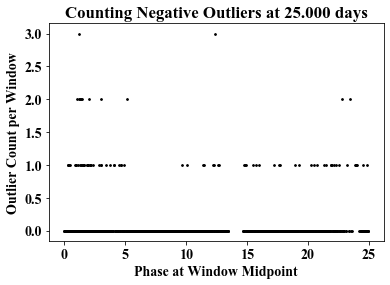

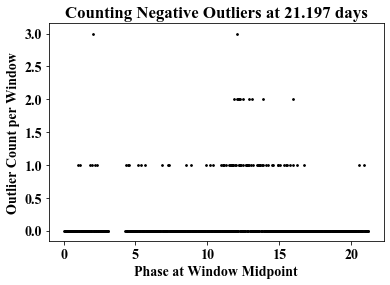

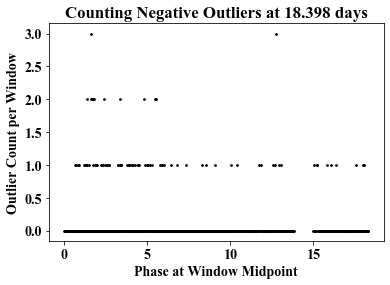

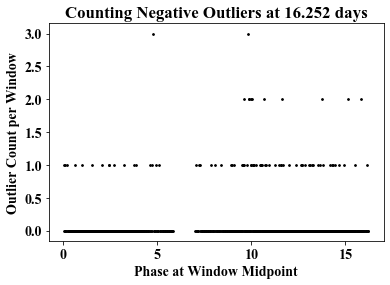

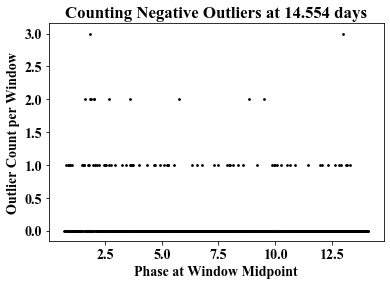

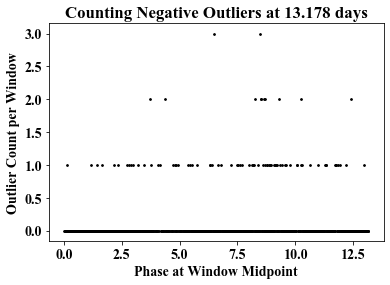

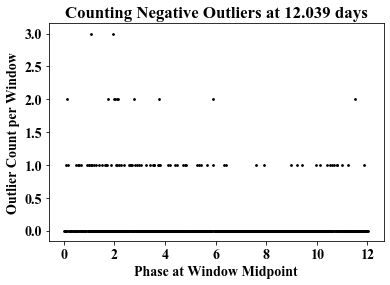

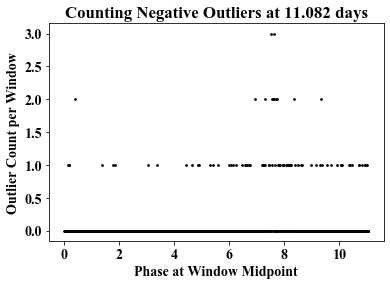

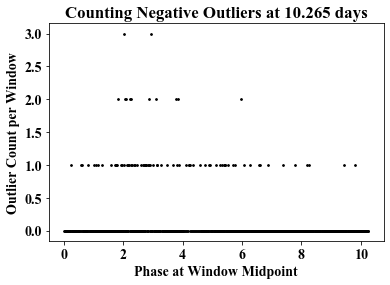

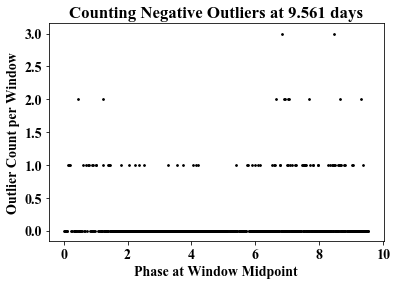

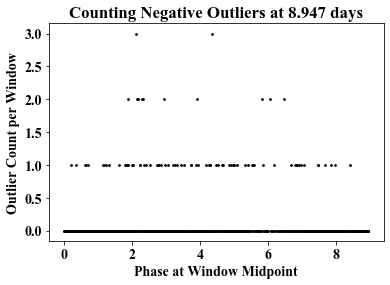

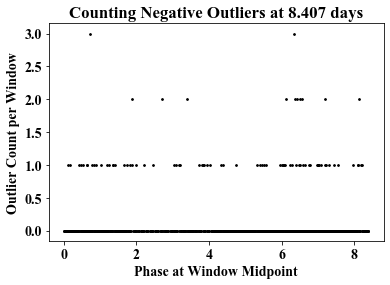

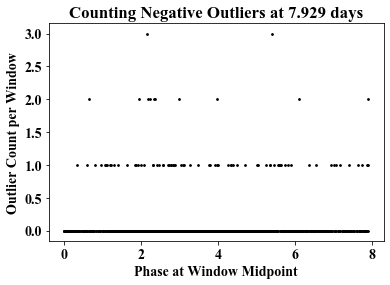

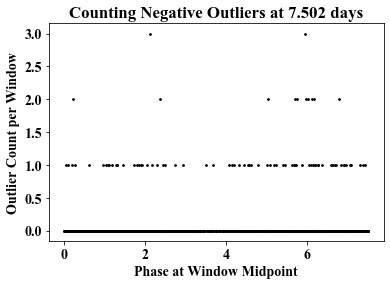

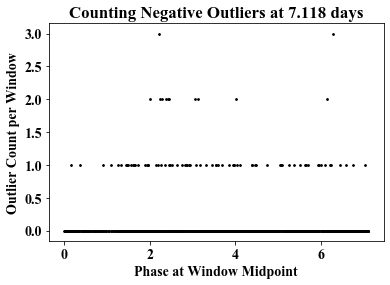

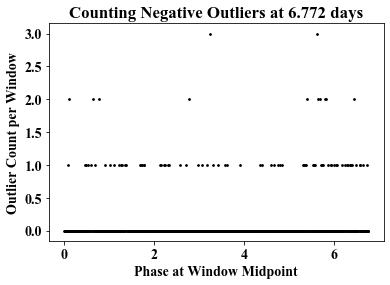

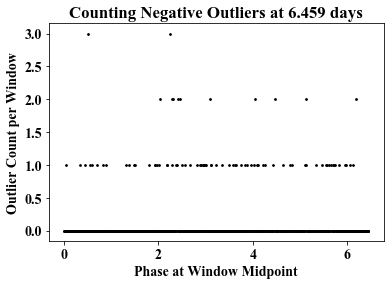

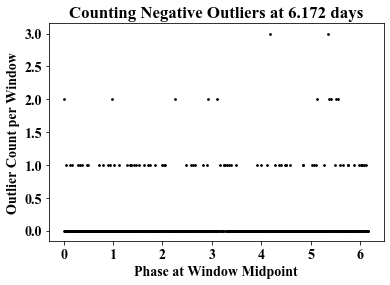

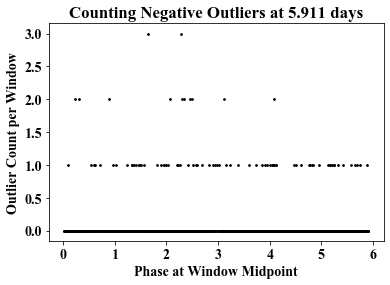

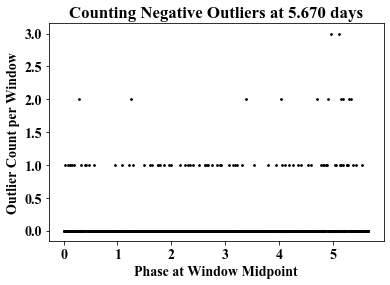

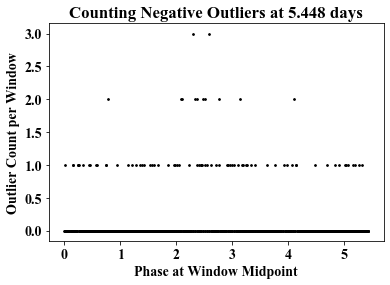

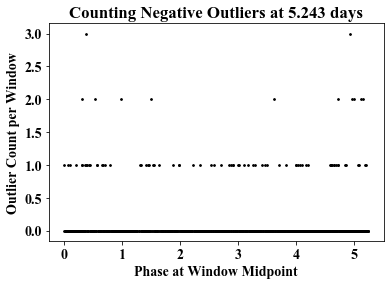

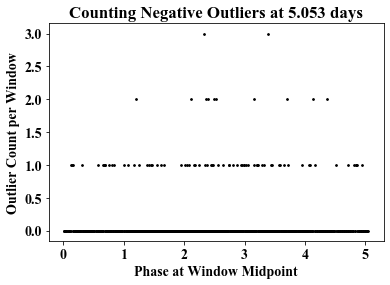

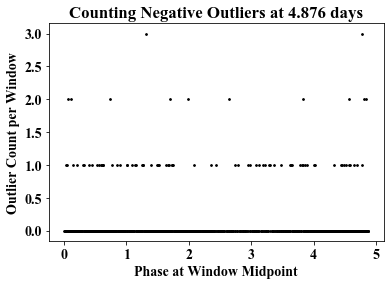

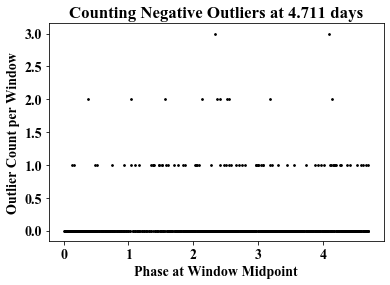

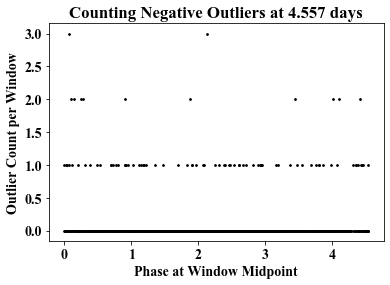

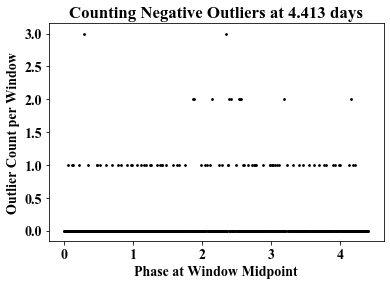

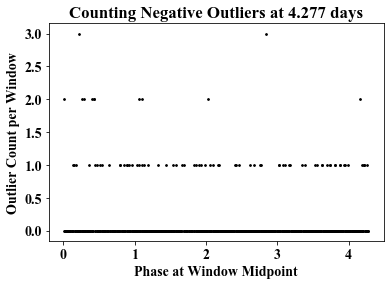

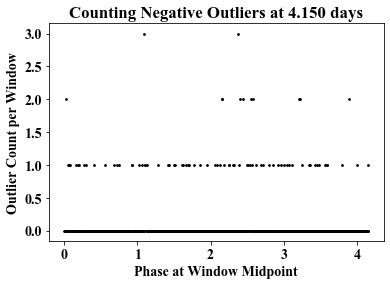

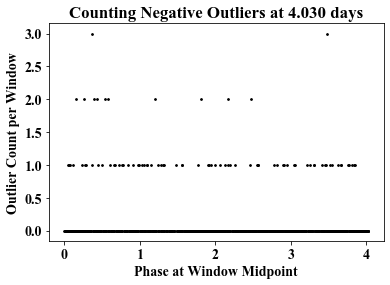

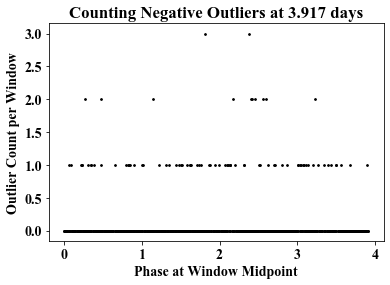

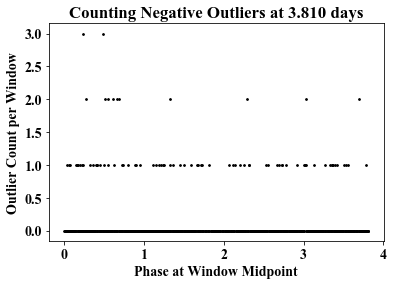

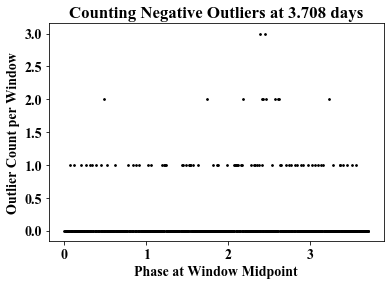

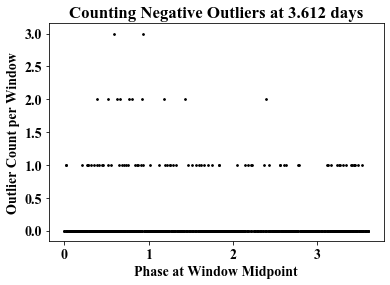

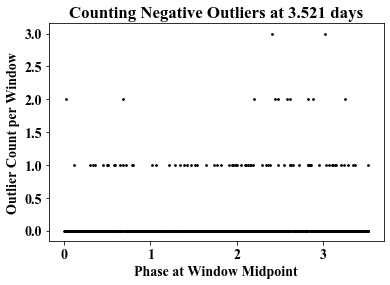

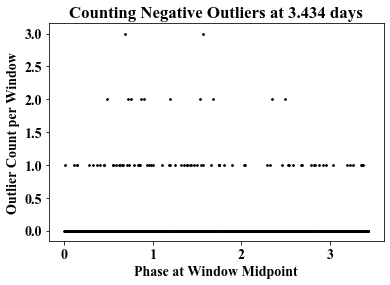

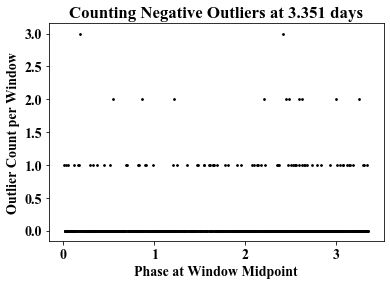

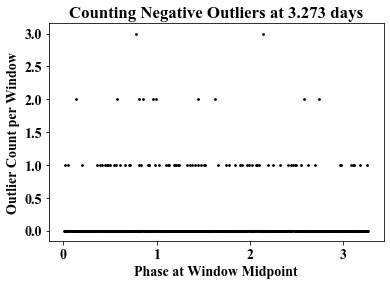

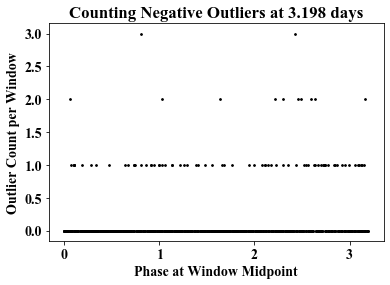

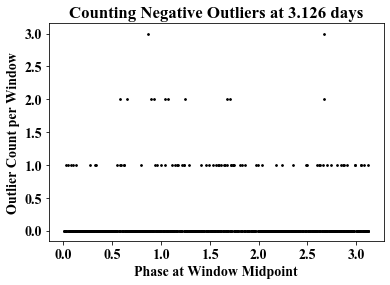

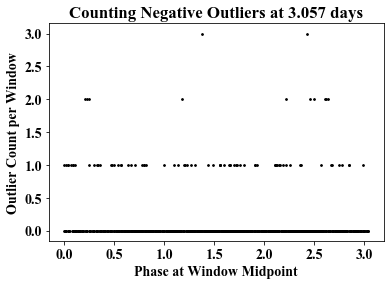

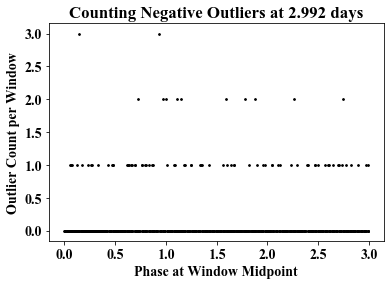

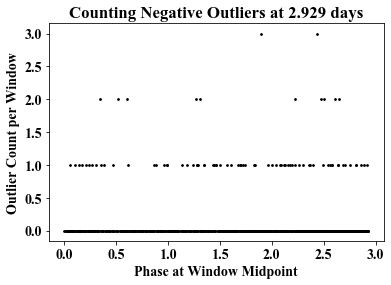

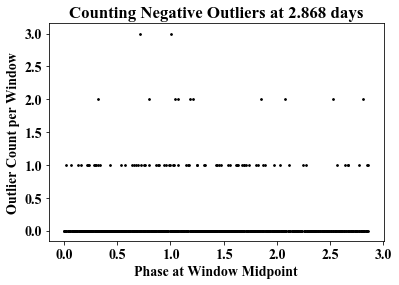

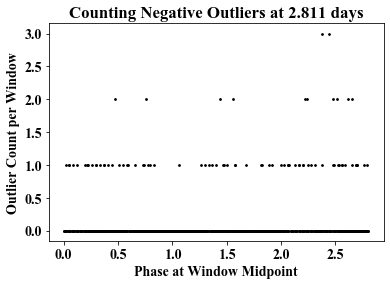

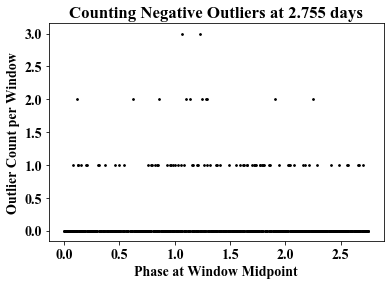

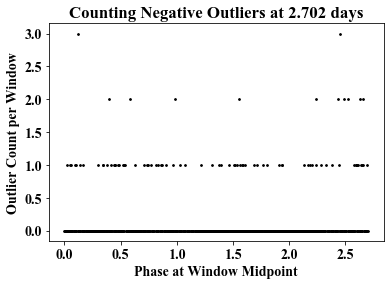

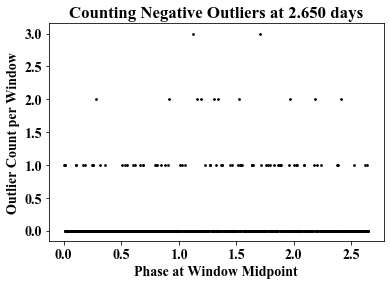

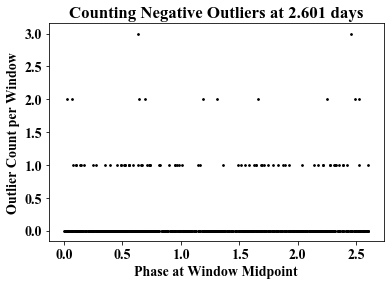

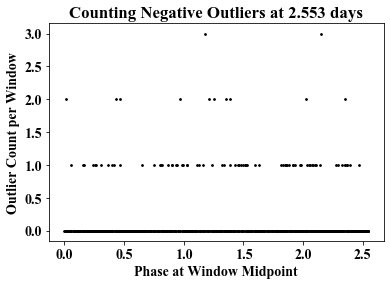

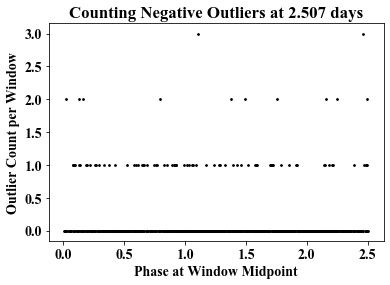

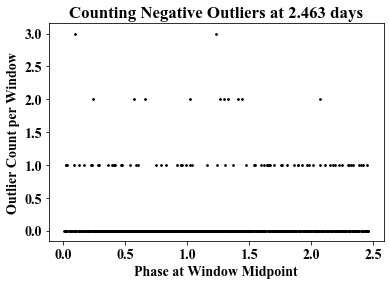

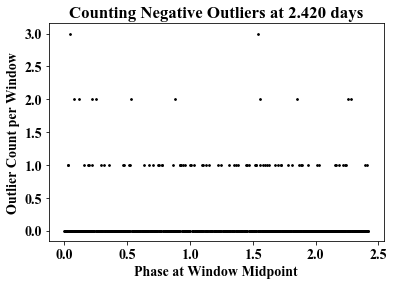

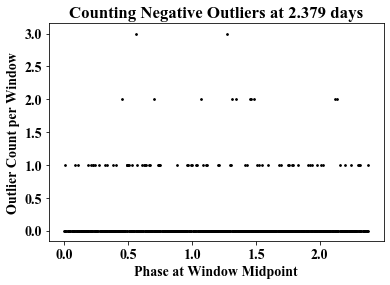

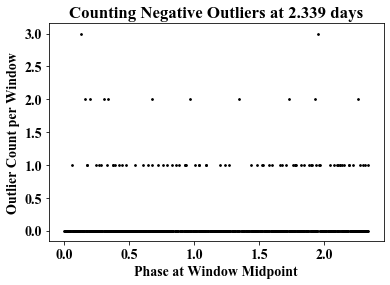

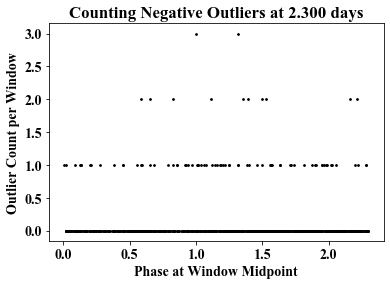

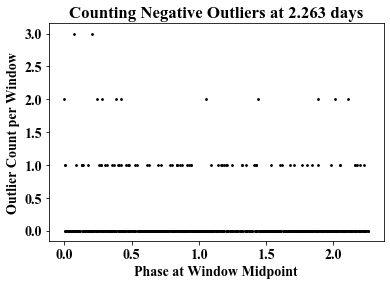

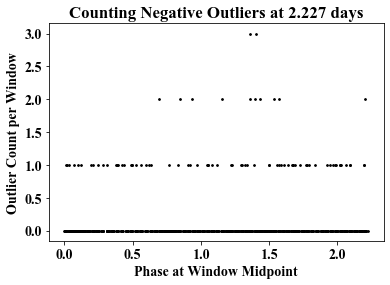

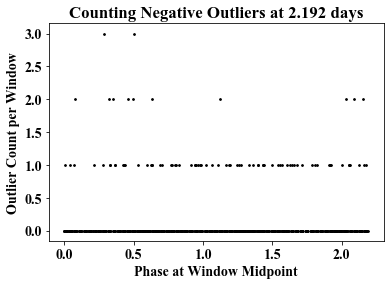

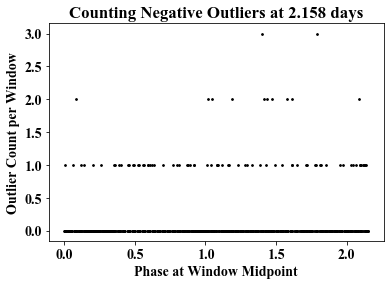

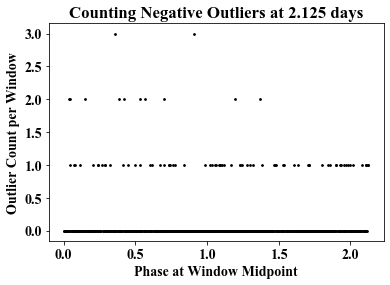

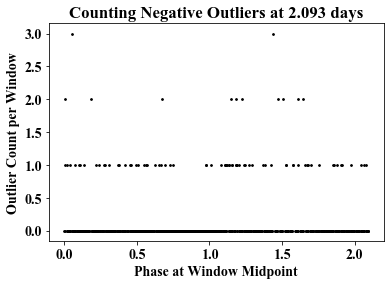

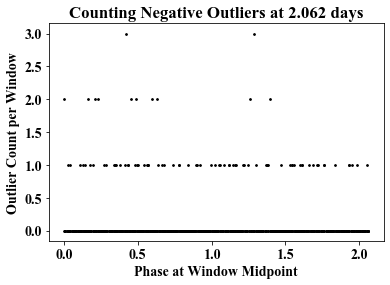

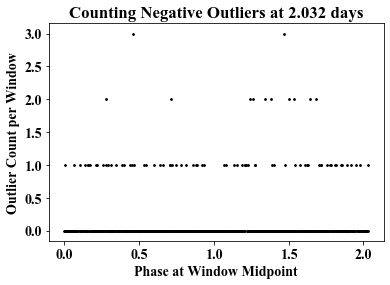

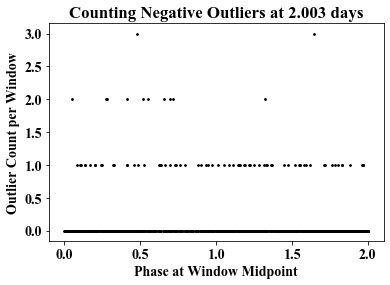

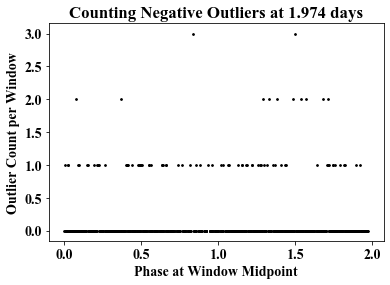

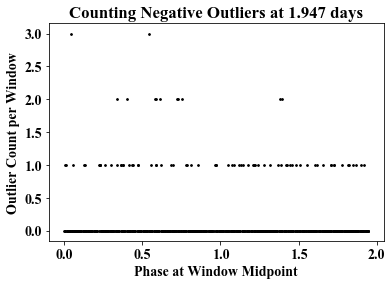

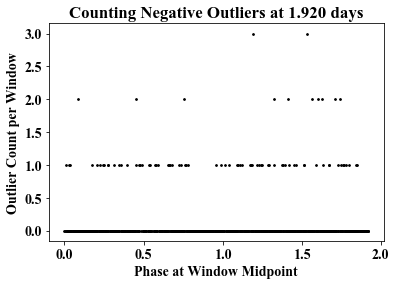

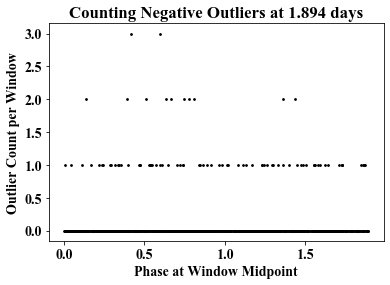

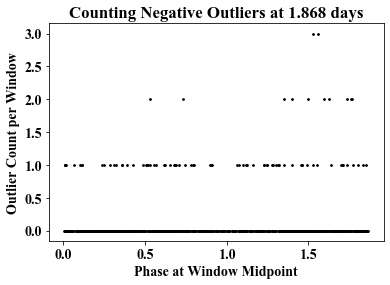

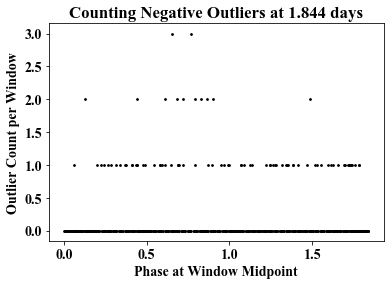

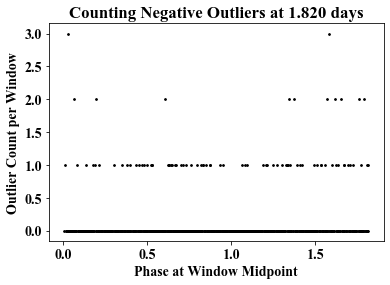

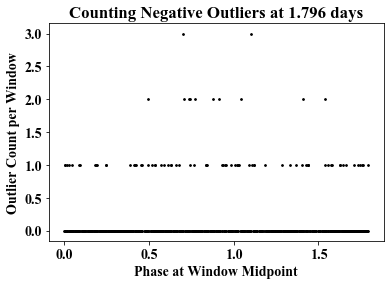

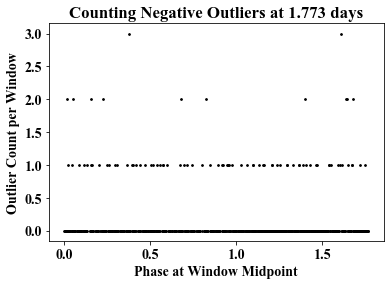

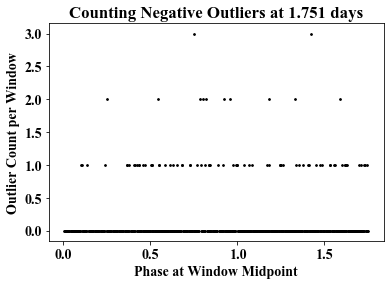

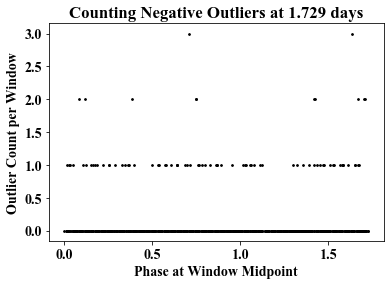

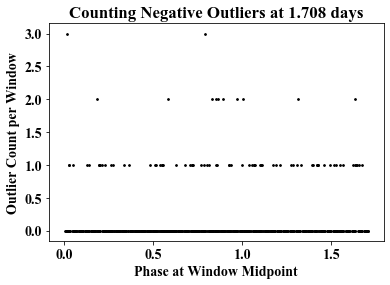

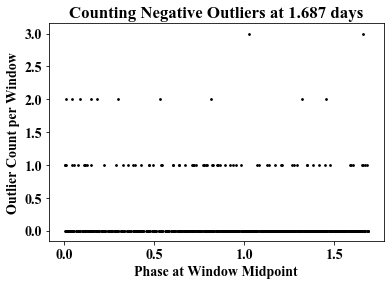

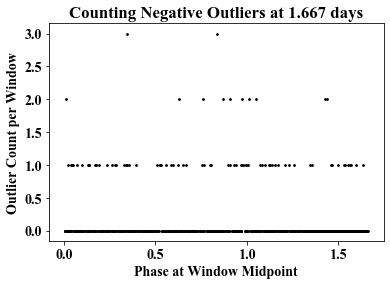

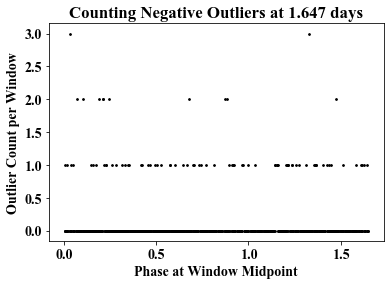

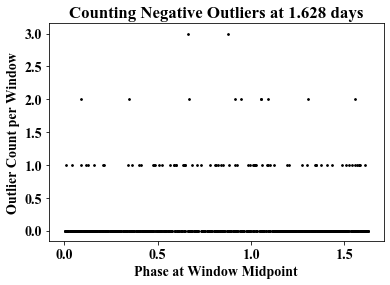

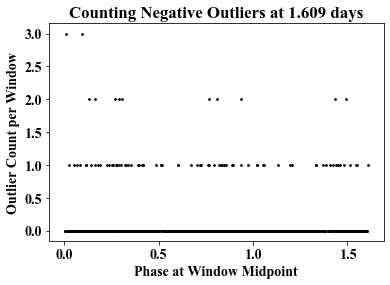

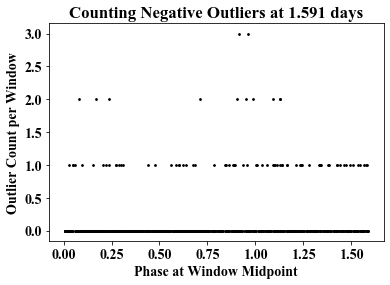

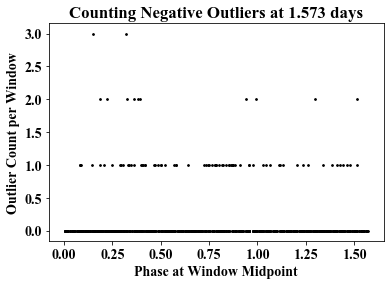

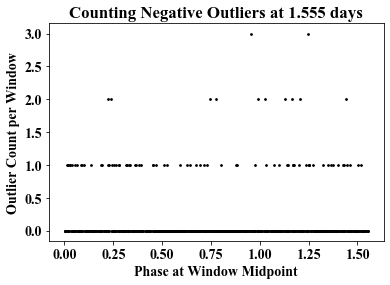

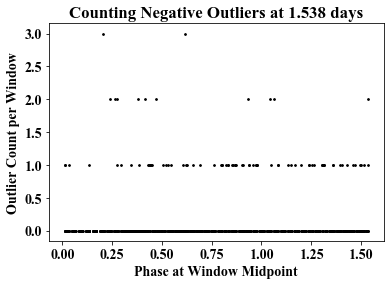

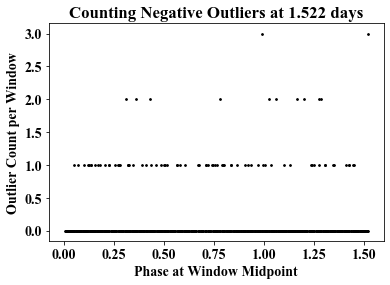

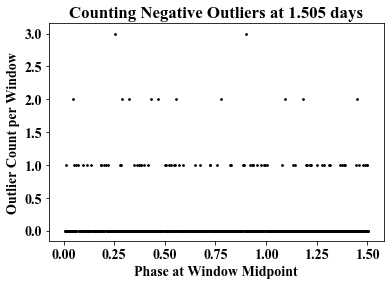

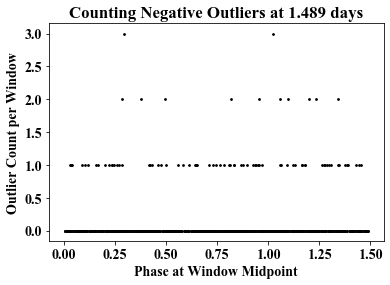

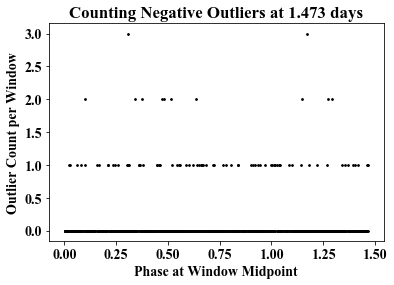

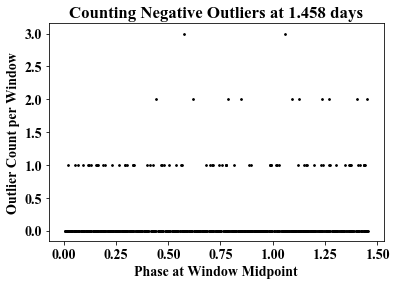

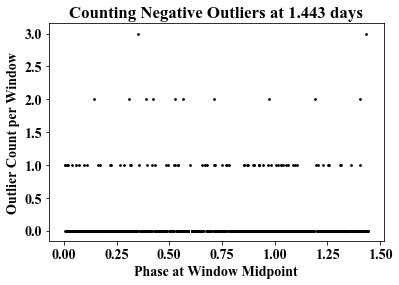

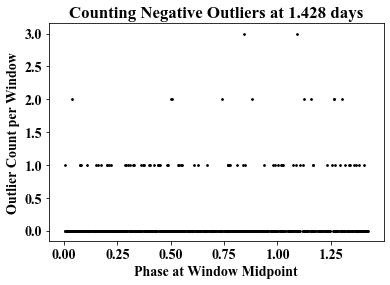

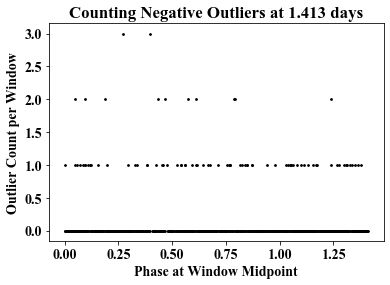

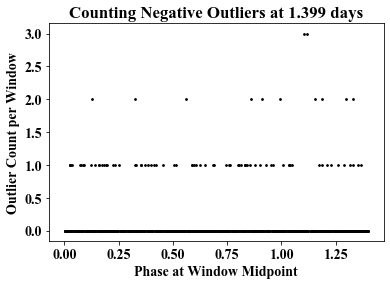

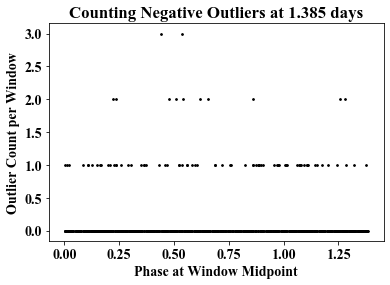

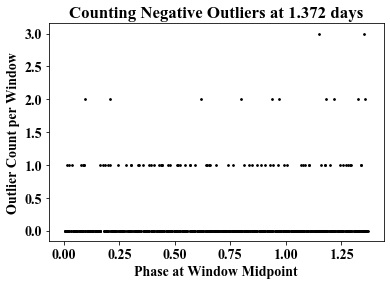

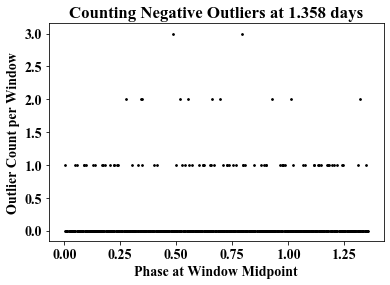

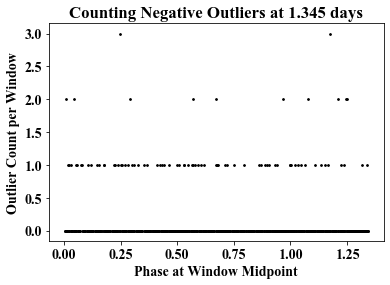

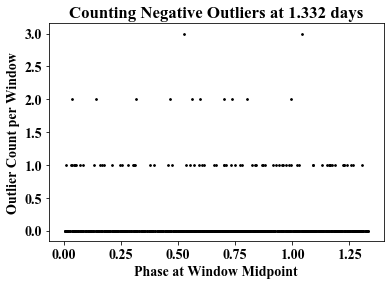

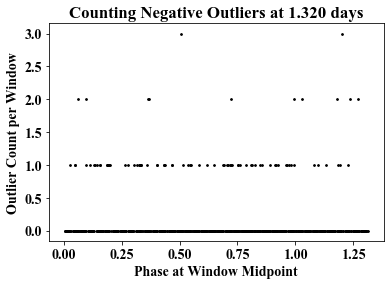

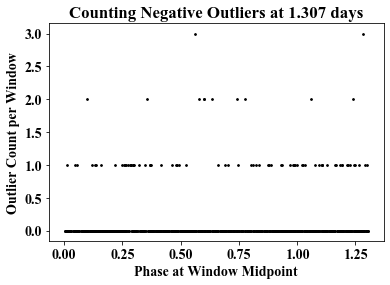

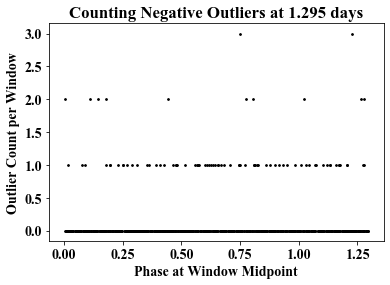

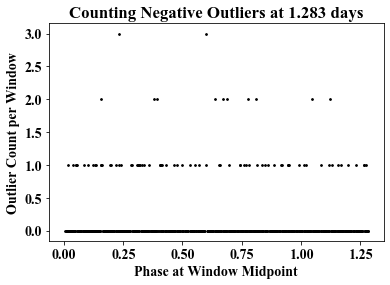

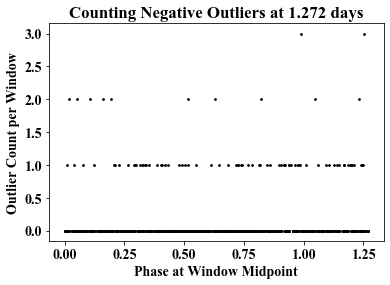

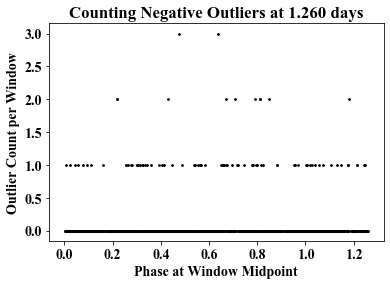

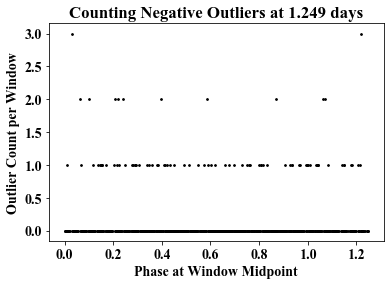

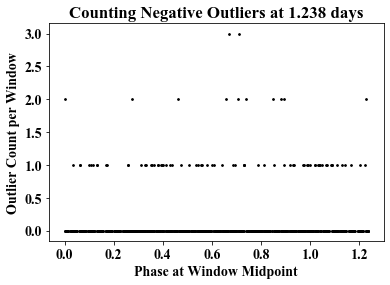

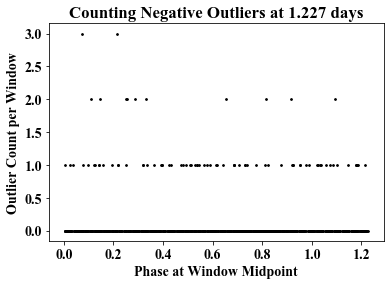

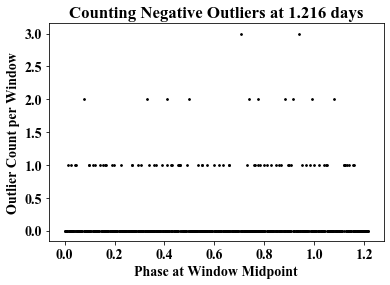

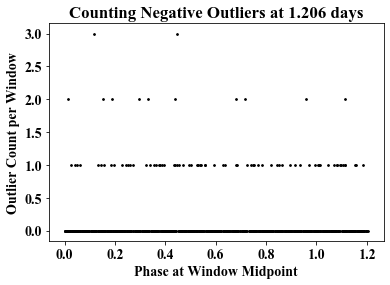

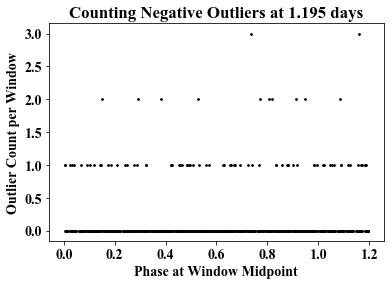

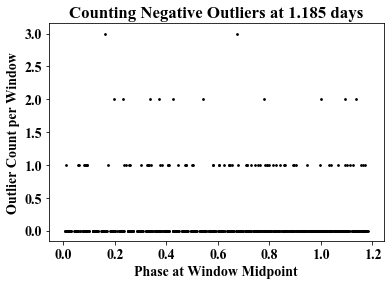

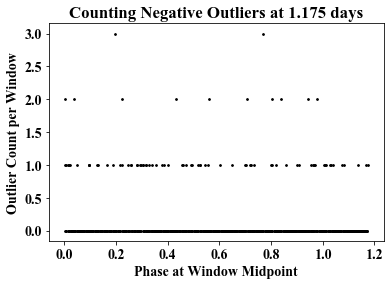

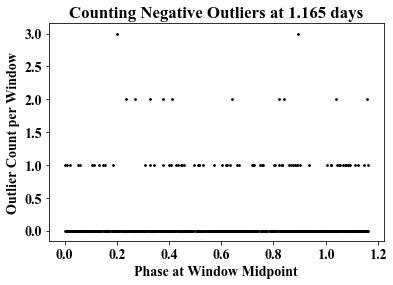

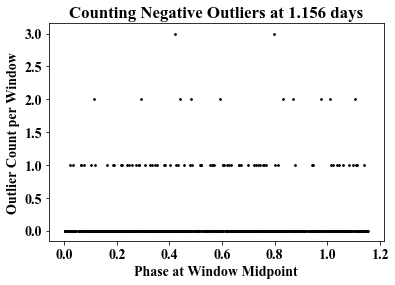

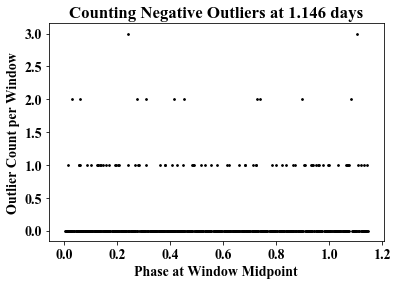

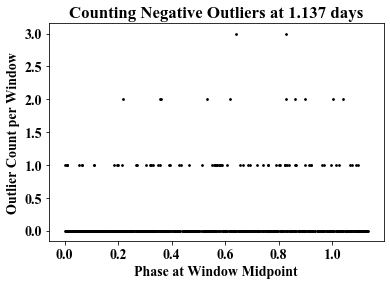

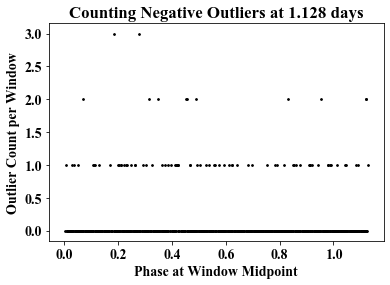

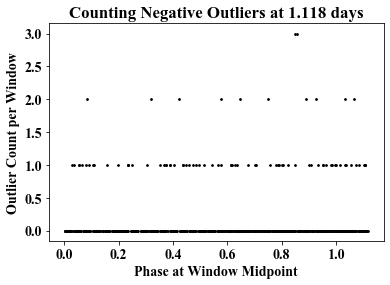

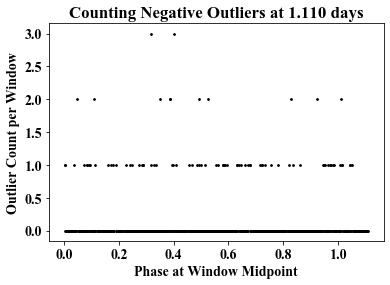

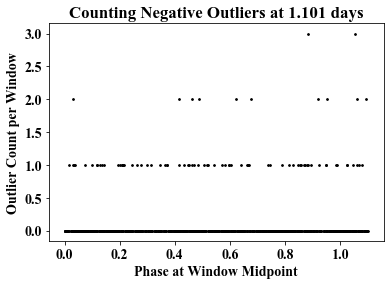

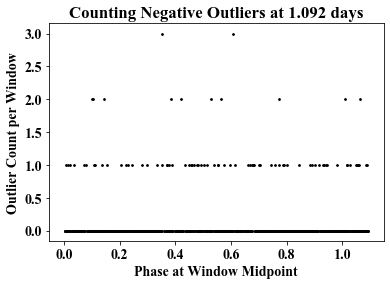

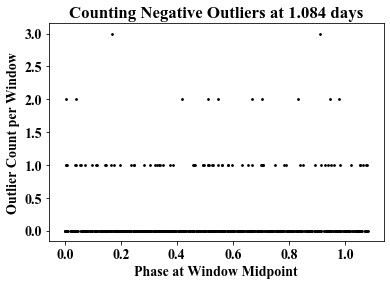

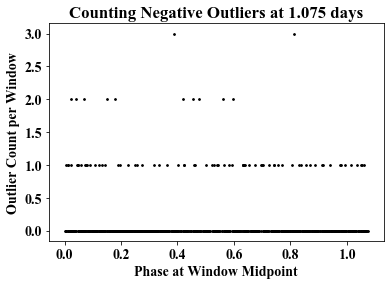

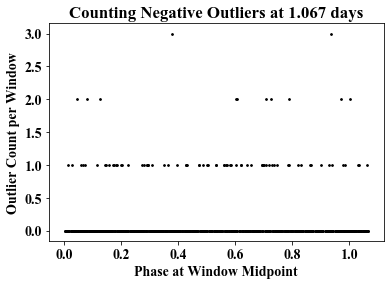

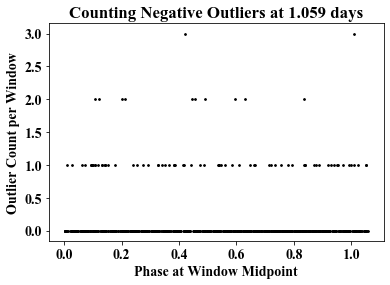

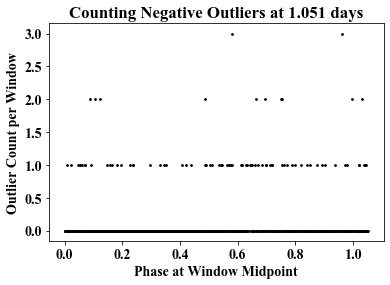

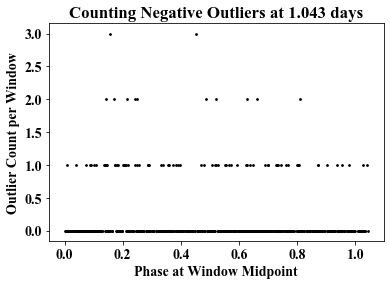

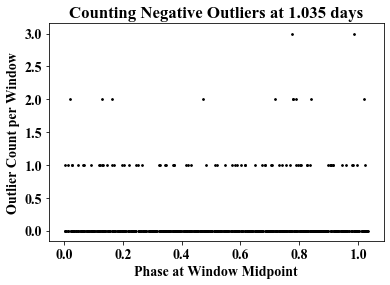

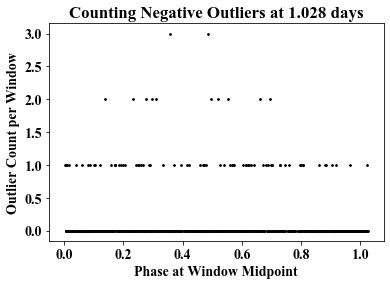

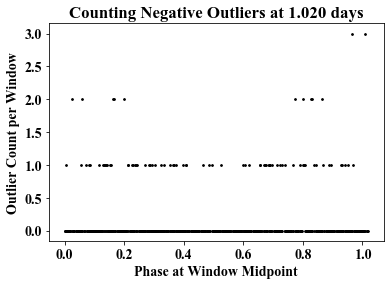

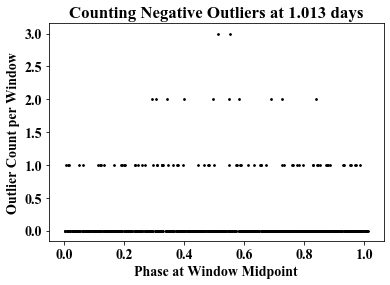

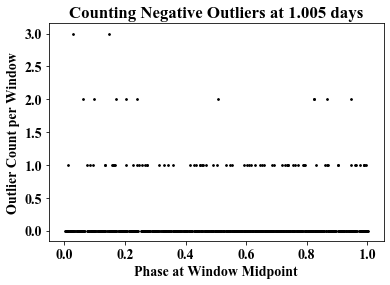

In [39]:
lcNew = lcTransit.copy()
lcNew.flux = removetrans(lcTransit)+1
gridfreqcount_new(lcNew, upper=25, lower=1, N=5)

## Applying CDF to the Outlier Count

In [ ]:
def countcdf(lc,N=10):
    periods=[]
    phases=[]
    time = max(lc.time)-min(lc.time)
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        #print(phase)
        
        ## Pos outlier removal below
        flux_nomad = lc.flux-1
        MAD = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)
        ## Pos outlier removal above
        
        ##Counting neg outlier below
        col = [0]*len(phase)
        col = np.array(col)
        col[np.where(flux_nomad <= -4*MAD)] = 1 #'r'
        windows = window(col, w=40, o=10)
        window_phase = window(phase, w=40, o=10)
        x = window_phase[:,0]
        xn = np.linspace(min(x), max(x), len(x))
        counts = []
        for j in range(0, len(windows)):
            outlier_count = np.count_nonzero(windows[j])
            counts.append(outlier_count)
        ##Counting neg outlier above
        
        ##CDF below
        
        c_cdf = np.sort(counts)
        y = c_cdf/c_cdf[-1]
        print(len(y)==len(x))
        #print(y)
        #print(x)
        #print(c_cdf)
        #p_cdf = np.sort(window_phase[:,0])
        #y_cdf = np.arange(1, len(x_cdf)+1) / len(x_cdf)
        
        ##CDF above
        print(x,y)
        print(np.sort(x))
        print(np.mean(x))
        
        plt.scatter(x, y, marker="o", color="k", s=3)
        plt.title("CDF of Outlier Count at {} days".format('%.3f'%(period)))
        plt.xlabel("Phase of Window Midpoint")
        plt.ylabel("CDF")
        plt.savefig(os.path.join(downloadDir,"CountCDF_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    #return periods

#countcdf(lcTransit)

## Polynomial Fit of CDF

In [ ]:
def countpolyfit(lc,N=10):
    periods=[]
    phases=[]
    time = max(lc.time)-min(lc.time)
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        
        ## Pos outlier removal below
        flux_nomad = lc.flux-1
        MAD = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)
        ## Pos outlier removal above
        
        ##Counting neg outlier below
        col = [0]*len(phase)
        col = np.array(col)
        col[np.where(flux_nomad <= -4*MAD)] = 1 #'r'
        #print(len(col))
        windows = window(col, w=40, o=10)
        window_phase = window(phase, w=40, o=10)
        x = window_phase[:,0]
        xs = np.sort(x)
        counts = []
        for j in range(0, len(windows)):
            outlier_count = np.count_nonzero(windows[j])
            counts.append(outlier_count)
        ##Counting neg outlier above
        
        ##CDF below
        c_cdf = np.sort(counts)
        y = c_cdf/c_cdf[-1]
        ##CDF above
        
        ##Polyfit below
        xp = np.linspace(min(xs), max(xs), len(xs))
        coefficients = np.polyfit(xs, y, deg=10) #test with deg=1 to see if the mean of the cdf appears
        polynomial = np.poly1d(coefficients)
        print(polynomial)
        yp = polynomial(xp)
        ##Polyfit above
        
        plt.scatter(xs, y, marker="o", color="k", s=3)
        #plt.plot(xp, yp, 'b-')
        plt.title("CDF of Outlier Count at {} days".format('%.3f'%(period)))
        plt.xlabel("Phase of Window Midpoint")
        plt.ylabel("CDF")
        #plt.savefig(os.path.join(downloadDir,"CountCDF_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    return periods

#countpolyfit(lcTransit)

## Derivative of Polynomial Fit